# Test model_62x62_3_e2_0528 #

## Oerview ##

|Model|Training Iteration|Test accuracy(Cosine Similarity)|Test accuracy (Euclidean Distance)|Test accuracy (Joint Bayesian)|
| ----|----|----|----|----|
|62x62_3_e2_0528|750,000|0.749333|0.701|0.60|

- [Test accuracy](#Test-accuracy)

## Dataset ##

|Dataset|People|Image|Size|
| ----|----|----- |----- |
|LFW-custom|5749|13233|62x62|

- testing set: 6000 people pairs on LFW-custom
  - images: official images aligned with deep funneling
  - slice: (width_scope, height_scope) = ((63, 187), (63,187))
  - resize: 0.5  

## Get LFW image pairs ## 

In [1]:
import sklearn
from sklearn.datasets import fetch_lfw_pairs
import numpy as np

In [2]:
lfwList = fetch_lfw_pairs(subset='10_folds', data_home='/workspace/datasets', funneled=True, resize=0.5, color=True, slice_=(slice(63, 187), slice(63, 187)), download_if_missing=True)

In [3]:
# pairs : numpy array of shape (6000, 2, 62, 62, 3)
# target : numpy array of shape (6000,)
leftParts = lfwList.pairs[:, 0, :, :, :]
rightParts = lfwList.pairs[:, 1, :, :, :]

assert(len(leftParts) == len(rightParts))

test_num = len(leftParts)

In [4]:
labels = lfwList.target

assert(len(labels) == test_num)

# transform label value
# origin:      0 => different, 1 => same
# transformed: 0 => same     , 1 => different

for i in range(labels.shape[0]):
    labels[i] = 1 - labels[i]

## Net settings ##

In [5]:
import caffe

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [6]:
MODEL_FILE = '/workspace/tools/deepid/model/62x62_3_e2_0528/snapshot/snapshot_iter_750000.caffemodel'
DEPLOY_FILE = '/workspace/tools/deepid/model/62x62_3_e2_0528/deploy.prototxt'

caffe.set_mode_gpu()
net = caffe.Net(DEPLOY_FILE, MODEL_FILE, caffe.TEST)

In [7]:
# load the mean image (as distributed with Caffe) for subtraction
mu = np.load('/workspace/datasets/CASIA-WebFace-custom/mean_528_62x62.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

In [8]:
# create transformer for the input called 'data_1'
transformer = caffe.io.Transformer({'data': net.blobs['data_1'].data.shape})

# (h,w,c) => (c,h,w)
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_input_scale('data', 0.0078125)

In [9]:
print 'network input:', net.inputs
print 'network output:', net.outputs

network input: ['data_1']
network output: ['deepid_1']


## Transform input data ##

In [10]:
X = np.empty((test_num, 3, 62, 62))

i = 0
for entry in leftParts:
    X[i, :, :, :] = transformer.preprocess('data', entry)
    i = i + 1

out = net.forward_all(data_1 = X)
feature_left = np.float64(out['deepid_1'])
feature_left = np.reshape(feature_left, (test_num, 160))

In [11]:
X = np.empty((test_num, 3, 62, 62))

i = 0
for entry in rightParts:
    X[i, :, :, :] = transformer.preprocess('data', entry)
    i = i + 1

out = net.forward_all(data_1 = X)
feature_right = np.float64(out['deepid_1'])
feature_right = np.reshape(feature_right, (test_num, 160))

## Test accuracy ##

**Dependency**

In [12]:
import cPickle as pickle
import sklearn
import sklearn.metrics.pairwise as pw
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [13]:
def calculate_accuracy(distance,labels,num):
    '''
    #计算识别率,
    选取阈值，计算识别率
    '''
    accuracy = []
    # predict = np.empty((num,))
    predict = np.empty(num)
    threshold = 0.2
    while threshold <= 0.8 :
        for i in range(num):
            if distance[i] >= threshold:
                 predict[i] = 1 # different
            else:
                 predict[i] = 0 # same
        predict_right = 0.0
        for i in range(num):
            if predict[i] == labels[i]:
              predict_right = 1.0 + predict_right
        current_accuracy = (predict_right/num)
        accuracy.append(current_accuracy)
        threshold = threshold + 0.001
    return np.max(accuracy)

In [14]:
def draw_roc_curve(fpr, tpr, title):
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC with ' + title + 'method on LFW')
    plt.legend(loc="lower right")
    plt.show()

### Test accuracy with Cosine Similarity method on LFW ###

[\[back to top\]](#Oerview)

In [15]:
# calculate features' distance with cosine similarity
mt = pw.pairwise_distances(feature_left, feature_right, metric='cosine')

In [16]:
predicts = np.empty(test_num)

for i in range(test_num):
    predicts[i] = mt[i][i]
    # 距离需要归一化到0--1,与标签0-1匹配
for i in range(test_num):
    predicts[i] = (predicts[i]-np.min(predicts))/(np.max(predicts)-np.min(predicts))

print 'accuracy is :', calculate_accuracy(predicts, labels, test_num)

accuracy is : 0.749333333333


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


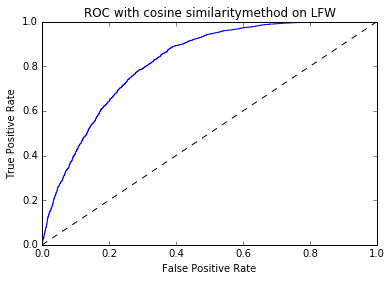

In [17]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predicts)

draw_roc_curve(fpr, tpr, title='cosine similarity')

In [18]:
# store result
fout = open('cosine-similarity-20160416-1.result.pkl', 'w')
data = {"distance": predicts, "label": labels}
pickle.dump(data, fout)
fout.close()

### Test accuracy with Euclidean Distance method on LFW ###

In [19]:
# calculate features' distance with cosine similarity
mt = pw.pairwise_distances(feature_left, feature_right, metric='euclidean')

In [20]:
predicts = np.empty(test_num)

for i in range(test_num):
    predicts[i] = mt[i][i]
    # 距离需要归一化到0--1,与标签0-1匹配
for i in range(test_num):
    predicts[i] = (predicts[i]-np.min(predicts))/(np.max(predicts)-np.min(predicts))

print 'accuracy is :', calculate_accuracy(predicts, labels, test_num)

accuracy is : 0.701


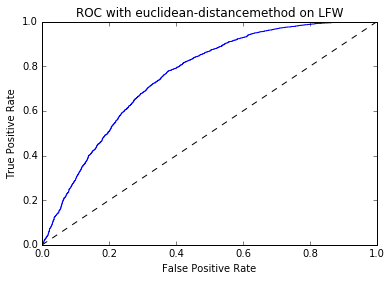

In [21]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predicts)

draw_roc_curve(fpr, tpr, title='euclidean-distance')

In [22]:
# store result
fout = open('euclidean-distance-20160416-1.result.pkl', 'w')
data = {"distance": predicts, "label": labels}
pickle.dump(data, fout)
fout.close()

### Test accuracy with Joint Bayesian method on LFW ###

- [joint-bayesian-20160416-2.log.train](./joint-bayesian-20160416-2.log.train)
- [joint-bayesian-20160416-2.log.test](./joint-bayesian-20160416-2.log.test)
- [joint-bayesian-20160416-2.result.pkl](./joint-bayesian-20160416-2.result.pkl)

**Prepare training set of Joint Bayesian**

In [23]:
# extract features through the trained DeepID model
# and store label_CASIA_Webface.mat, feature_CASIA_Webface.mat

# !python /workspace/tools/face-preprocess-tools/feature_extractor_mat.py

**Train and test Joint Bayesian model**

- tool: [cyh24/Joint-Bayesian](https://github.com/cyh24/Joint-Bayesian)

In [24]:
# train and test Joint Bayesian model
# and store joint-bayesian-2016xxxx-x.log, joint-bayesian-2016xxxx-x.result.pkl

# !python /workspace/tools/Joint-Bayesian/src/test_lfw.py

In [25]:
!tail ./joint-bayesian-20160416-2.log.test


avg / total       0.59      0.59      0.59      6000

threshold:  1.69489139171
             precision    recall  f1-score   support

      False       0.61      0.54      0.57      3000
       True       0.59      0.65      0.62      3000

avg / total       0.60      0.60      0.60      6000

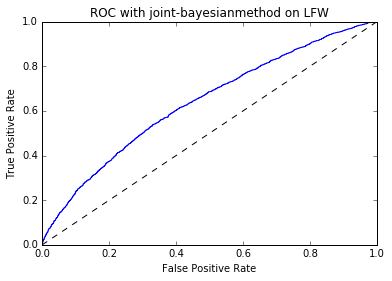

In [26]:
f = open('joint-bayesian-20160416-2.result.pkl', 'r')

result = pickle.load(f)
dist = result['distance']
y    = result['label']

f.close()

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, dist)

draw_roc_curve(fpr, tpr, title='joint-bayesian')